# Planet : Amazon space

In [1]:
import os
import torch
import pandas as pd
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, io
import torch.nn as nn
from torchinfo import summary

import torchvision.transforms.functional as F

C:\Users\gezas\anaconda3\envs\IPEO\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_folder = '../IPEO_Planet_project'
if not os.path.exists(data_folder):
    data_folder = input("Enter the data folder path: ")
    assert os.path.exists(data_folder), "I did not find the folder at, "+str(data_folder)

# Loading the dataset

### Understanding the labels

In [3]:
labels_dt = pd.read_csv(f'{data_folder}/train_labels.csv',dtype=str)
print(labels_dt.head())
print(f" \n Shape of the initial dataset {labels_dt.shape}")

  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road
 
 Shape of the initial dataset (40479, 2)


In [4]:
label_test =  labels_dt.iloc[0,1]
print(label_test)
print(type(label_test))
print(f'Splited labels example: {label_test.split()}')

haze primary
<class 'str'>
Splited labels example: ['haze', 'primary']


In [74]:
tags = pd.Series(labels_dt['tags'].str.split(expand=True).stack().unique())
print(F"Unique tags are: \n{tags}")
print(len(tags))

Unique tags are: 
0                  haze
1               primary
2           agriculture
3                 clear
4                 water
5            habitation
6                  road
7           cultivation
8            slash_burn
9                cloudy
10        partly_cloudy
11    conventional_mine
12          bare_ground
13       artisinal_mine
14             blooming
15    selective_logging
16            blow_down
dtype: object
17


In [75]:
for tag in tags:
     a = [(tag in i.split()) for i in labels_dt['tags']]
     new_col = np.zeros(len(a),dtype=int)+a
     #print(new_col.shape)
     labels_dt[tag]=new_col

In [76]:
labels_dt

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40474,train_40474,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
40475,train_40475,cloudy,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
40476,train_40476,agriculture clear primary,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
40477,train_40477,agriculture clear primary road,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0


### Understanding the images

../IPEO_Planet_project/train-jpg\train_5.jpg


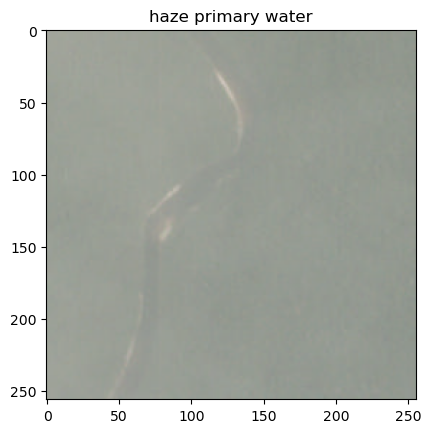

In [77]:
id_test = 5
img_name_test = os.path.join(f'{data_folder}/train-jpg', labels_dt.iloc[id_test, 0])
img_name_test = f'{img_name_test}.jpg'
print(img_name_test)

plt.figure()
plt.title(labels_dt.iloc[id_test,1])
img = imread(img_name_test)
#img = F.to_pil_image(image)
plt.imshow(img)

## Custom made Class for multilabel classification

See this tutorial for help:
<https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>

In [64]:
class AmazonSpaces(Dataset):
    """Amazon aerial image dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)
        self.tags = self.labels['tags'].str.split(expand=True).stack().unique()
        for tag in self.tags:
            a = [(tag in i.split()) for i in self.labels['tags']]
            self.labels[tag]=np.zeros(len(a),dtype=int)+a

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels.iloc[idx, 0])
        img_name = f'{img_name}.jpg'

        image = imread(img_name)
        labels = self.labels.loc[idx, self.tags].tolist()
        
        #other output
        #sample = {'image': image, 'labels': labels}

        if self.transform:
            image = self.transform(image)

        return image, labels

In [65]:
Amazon_dataset = AmazonSpaces(csv_file=f'{data_folder}/train_labels.csv',
                                    root_dir=f'{data_folder}/train-jpg')

## Having some fun with transforms
Just testing some transforms and how to implement into dataset
First creating and Adjust_Saturation class to be able to apply adjust_saturation the same way as the other transforms class

In [66]:
class AdjustSaturation(object):
    """Adjust the saturation of a tensor image.
    Args:
        saturation factor (float): if 0 -> black and white, if 1 -> same as the input
    """

    def __init__(self, saturation_factor):
        assert isinstance(saturation_factor, (int,float))
        self.saturation_factor = saturation_factor

    def __call__(self, img):
        new_tensor = transforms.functional.adjust_saturation(img, self.saturation_factor)

        return new_tensor

In [67]:
Test_transforms = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256),transforms.RandomAutocontrast(p=1), AdjustSaturation(2)])

In [68]:
transformed_dataset = AmazonSpaces(csv_file=f'{data_folder}/train_labels.csv',
                                    root_dir=f'{data_folder}/train-jpg', transform=Test_transforms)

## Visualizing the two datasets:
1) The dataset without transforms

In [100]:
id_test = 5
img, labels = Amazon_dataset[id_test]
idx = np.arange(0,len(labels))[labels]
print(bool(labels))
print(labels_dt[bool(labels)])

True


KeyError: True

0                  haze
1               primary
2           agriculture
3                 clear
4                 water
5            habitation
6                  road
7           cultivation
8            slash_burn
9                cloudy
10        partly_cloudy
11    conventional_mine
12          bare_ground
13       artisinal_mine
14             blooming
15    selective_logging
16            blow_down
dtype: object
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


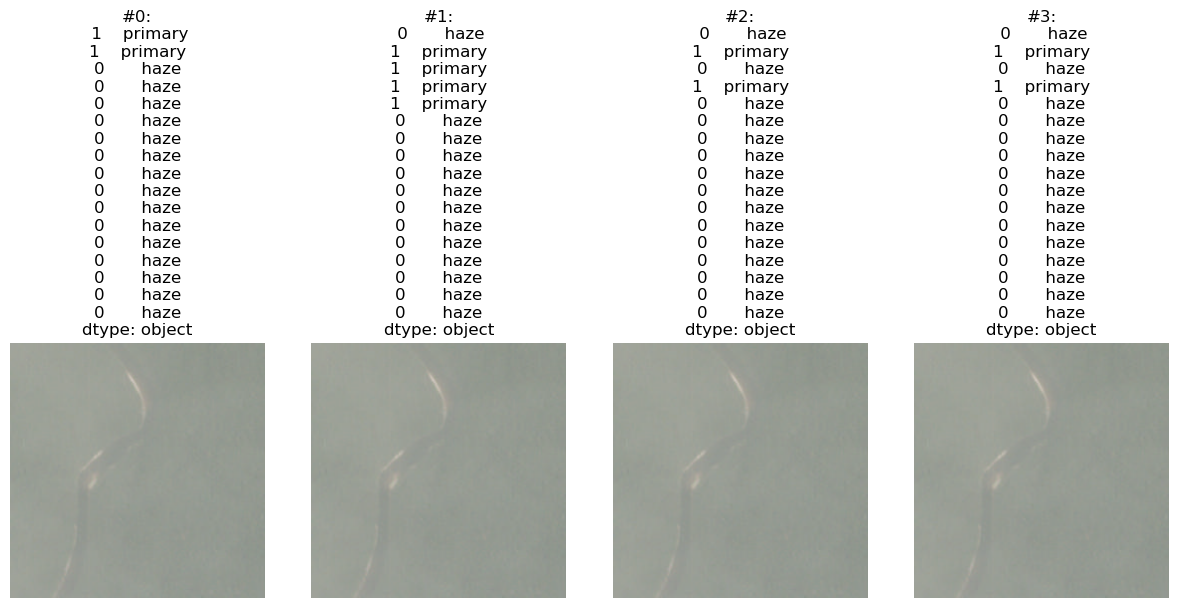

In [86]:

plt.figure(figsize=(12,10))
print(tags)
N=3
for i in range(len(Amazon_dataset)):
    #sample = Amazon_dataset[i]
    #print(i, sample['image'].shape, sample['labels']) #old class output
    #labels = sample['labels']
    #image = sample['image']
    image, labels = Amazon_dataset[i]
    #print(i, type(image), len(labels))
    ax = plt.subplot(1, N+1, i + 1)
    plt.tight_layout()
    print(labels)
    ax.set_title(f'#{i}:\n {tags[labels]}')
    ax.axis('off')
    #img = F.to_pil_image(image)
    ax.imshow(img)
    if i == N:
        plt.show()
        break

2) Then the one with tranforms

0 torch.Size([3, 256, 256]) 17
1 torch.Size([3, 256, 256]) 17
2 torch.Size([3, 256, 256]) 17
3 torch.Size([3, 256, 256]) 17


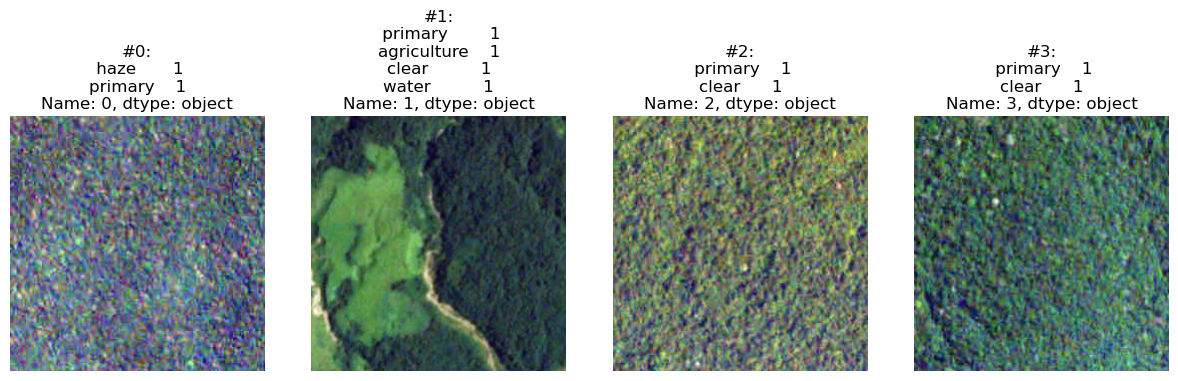

In [42]:
plt.figure(figsize=(12,10))

for i in range(len(transformed_dataset)):
    ## old class output:
    #sample = transformed_dataset[i]
    #print(i, sample['image'].shape, sample['labels'])
    #labels = sample['labels']
    #image = sample['image']

    image,labels = transformed_dataset[i] #new clas output

    print(i, image.shape, len(labels))
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'#{i}:\n {labels[labels[tags]==1]}')
    ax.axis('off')
    img = F.to_pil_image(image)
    ax.imshow(img)
    if i == 3:
        plt.show()
        break

# Into Dataloader

In [43]:
train_loader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

## Testing with plotting

In [46]:
# Helper function to show a batch
def show_image_batch(sample_batched):
    images_batch, labels = sample_batched['image'], sample_batched['labels'] #old class output
    #images_batch, labels = sample_batched
    batch_size = len(images_batch)
    fig, axs = plt.subplots(1, batch_size)
    for i in range(batch_size):
        #img = F.to_pil_image(images_batch[i])
        axs[i].imshow(img)
        axs[i].set_title(f'#{i}:\n {labels[i]}')
    fig.set_figheight(10)
    fig.set_figwidth(12)
    plt.tight_layout()
    plt.show()

In [47]:
i_batch = 0
for sample_batched in train_loader:
    # observe 4th batch and stop.
    if i_batch == 3:
        show_image_batch(sample_batched)
        break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.series.Series'>

# Multi-Layer convulotional network
## Model

* torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
* torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
* torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)

In [ ]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size = 5) #Input is a 3 plane 256x256 tensor (RBB) -> output 10 planes of 254x254
        self.pool_max = nn.MaxPool2d(2, 2) #output of dim-2 x dim-2
        self.conv2 = nn.Conv2d(10, 20, 5) #input 10 planes 127x127, output 20 planes of 125x125
        self.pool_avg = nn.AvgPool2d(4,4)
        self.fc = nn.Linear(20*27*27,17) #single dense layer for the network
        self.batchNorm = nn.BatchNorm1d(256)
        self.loss = nn.BCELoss()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.batchNorm(x)
        print(f"step 1 : {x.shape}")
        x = self.pool_max(nn.functional.relu(self.conv1(x)))
        print(f"step 2 : {x.shape}")
        x = self.pool_avg(x)
        print(f"step 3 : {x.shape}")
        x = nn.functional.relu(self.conv2(x))
        print(f"step 4 : {x.shape}")
        x = x.view(-1, 20*27*27)
        print(f"step 5 : {x.shape}")
        x = self.fc(x)
        return x

In [ ]:
net = MultiLayerCNN()
summary(net,input_size=(3,256,256))

## Training, Validation and accuracy functions

In [ ]:
def validate(net, dataloader,loss_fn=nn.BCELoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels)
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

In [ ]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

In [ ]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=2,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res